### Code to aggregate NASA LIS data to GRACE mascons

- LIS data provided by Sujay Kumar's group. Metadata located [here](https://lis.gsfc.nasa.gov/)

- authors: Helen Deweese, Anthony Arendt, APL/eScience, UW

### Load the packages

In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import signal
import scipy.optimize
import geopandas as gpd
import pandas as pd
import s3fs
from PyAstronomy import pyasl
import xarray as xr
from datetime import datetime, timedelta
import cartopy.crs as ccrs

matplotlib.style.use('ggplot')

from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis, select_mascons, aggregate_mascons)
from himatpy.LIS.utils import (get_xr_dataset)

import warnings
warnings.filterwarnings('ignore')

/home/yingjung_cd/miniconda3/envs/himat/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/yingjung_cd/miniconda3/envs/himat/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### Load the LIS data into xarray

In [2]:
datadir = '../../files/LIS/monthly/'

### Keep only the groundwater storage variable

In [3]:
LIS = get_xr_dataset(datadir=datadir, twoDcoords = False, keepVars = ['GWS_tavg'], multiple_nc=True)
LIS = LIS / 10. # convert mm to cm for later comparison with GRACE

### Plot one time slice to check on the data

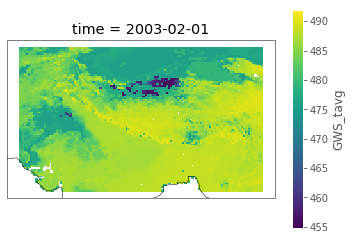

In [4]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
LIS.GWS_tavg[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),x='long',y='lat', add_colorbar=True)
ax.coastlines()

## read the groundwater well district shapefile

In [5]:
fp="../../files/Groundwater/dugwells_districts_d.shp"

In [6]:
GW_well_district = gpd.read_file(fp)

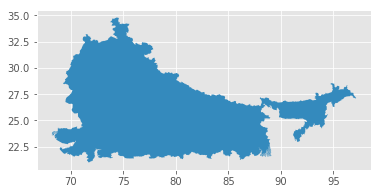

In [7]:
GW_well_district.plot()

### Open the GRACE data file

- [Dataset Source](https://neptune.gsfc.nasa.gov/gngphys/index.php?section=413)
- [Dataset Documentation](https://neptune.gsfc.nasa.gov/uploads/images_db/GSFC_mascons_HDF5_format_v02_3.pdf)

In [8]:
fileName = '../../files/GRACE/GSFC.glb.200301_201607_v02.4-ICE6G.h5'
grace_file = os.path.abspath(fileName)
f = extract_grace(grace_file, printGroups=False)

Data extracted: 


In [9]:
mascon = f['mascon']
soln = f['solution']
time = f['time']

mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


### Clip the GRACE mascons to the domain of the LIS data

In [10]:
mascon_gdf_masked = select_mascons(LIS, mascon_gdf)

### The main processing step that calculates a mean groundwater storage value across each mascon

In [11]:
agg_data = aggregate_mascons(LIS, mascon_gdf_masked)

### Convert aggregated groundwater storage data to Pandas dataframe for plotting

In [12]:
A = agg_data['data']

names = ['products', 'mascons', 'time']
index = pd.MultiIndex.from_product([agg_data[n] for n in names], names=names)
LISdf = pd.DataFrame({'A': A.flatten()}, index=index)['A']
LISdf = LISdf.unstack(level='products').swaplevel().sort_index()
LISdf.columns = agg_data['products']
LISdf.index.names = ['date','mascon']
# drop the na values
LISdf.dropna(how='any', inplace=True)

### Convert GRACE time series to Pandas dataframe

In [13]:
t = pd.DataFrame(data = {
    'time': f['time']["ref_days_middle"][0,:]
})

grc_lst = []
for m in agg_data['mascons']:
    df = pd.DataFrame(data={
        'cmwe': soln['cmwe'][m][:],
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)
    
gracedf = pd.concat(grc_lst)

### Make a plot of the mean GRACE and groundwater storage over the full domain

In [14]:
GWS_spatialMean = LISdf.groupby('date').mean() 
GRACE_spatialMean = gracedf.groupby('time').mean() 

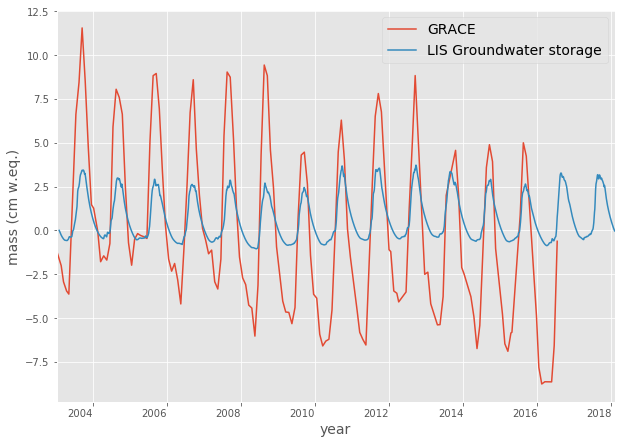

In [15]:
fig, ax = plt.subplots(1, figsize=(10, 8))
GRACE_spatialMean.plot(ax=ax, y='cmwe')
(GWS_spatialMean - GWS_spatialMean.iloc[0].values).plot(ax=ax, y='GWS_tavg')
plt.ylabel('mass (cm w.eq.)', fontsize = 14)
plt.xlabel('year', fontsize = 14) #'year'
plt.xticks(rotation=0)
ax.legend(['GRACE','LIS Groundwater storage'],fontsize = 14, loc = 1)
font = {'family' : 'Times',
        'size'   : 14}
matplotlib.rc('font', **font)


### Calculate the annual trend in GRACE mass, per mascon

In [16]:
GRACE_annual_trend=get_cmwe_trend_analysis(mascon_gdf_masked, f)

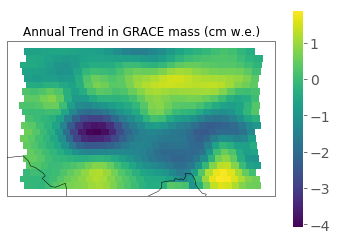

In [17]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
mascon_gdf_masked.plot(ax=ax, column='avg_mass_change_cm',cmap='viridis', legend=True)
plt.title('Annual Trend in GRACE mass (cm w.e.)', size = 12)
ax.coastlines()

### Clip to the shapefile boundary for which we have groundwater data

In [18]:
GRACE_annual_trend_clipped = gpd.overlay(GW_well_district,GRACE_annual_trend, how='intersection')

### Calculate LIS GWSA trend

#### Convert the date from multiindex into date column

In [19]:
LISdf1 = LISdf.reset_index()

### Calculate LIS GWSA trend per mascon

In [20]:
LIS_annual_trend=pd.DataFrame()
LIS_annual_trend['trend']=LISdf1.groupby('mascon').apply(lambda x: trend_analysis(x['date'].apply(lambda x: pyasl.decimalYear(x)), 
                                                   x['GWS_tavg'], optimization = True)[1] )

### Join the LIS groundwater trends with the mascon dataframe so that we can get geometries

In [21]:
LIS_annual_trend_geom = GRACE_annual_trend_clipped.join(LIS_annual_trend, on='mascon')

### Plot the spatial trend of each mascon for the groundwater data

Text(0.5, 55.92319665921714, 'longtitude')

<Figure size 1152x864 with 0 Axes>

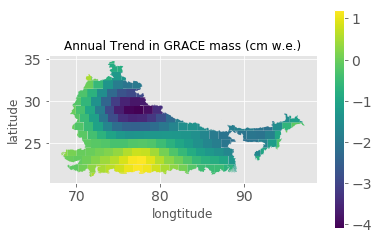

In [22]:
plt.figure(figsize=(16,12))
GRACE_annual_trend_clipped.plot(column='avg_mass_change_cm', cmap='viridis', legend=True)
plt.title('Annual Trend in GRACE mass (cm w.e.)', size = 12)
plt.ylabel('latitude', fontsize = 12)
plt.xlabel('longtitude', fontsize = 12)

Text(0.5, 55.92319665921714, 'longtitude')

<Figure size 864x576 with 0 Axes>

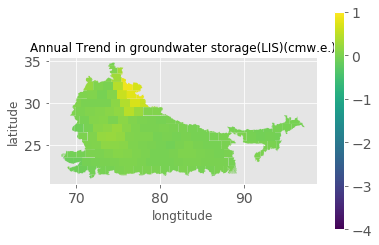

In [25]:
plt.figure(figsize=(12,8))
LIS_annual_trend_geom.plot(column='trend',cmap='viridis',vmin=-4,vmax=1, legend=True) 
plt.title('Annual Trend in groundwater storage(LIS)(cmw.e.)', size = 12)
plt.ylabel('latitude', fontsize = 12)
plt.xlabel('longtitude', fontsize = 12)